In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

%load_ext tensorboard

_include_('curriculum_vqa')
_include_('commons')

data_bin = f'{DEV_HOME}/curriculum_vqa/data-bin'

In [3]:
from cvqa import datasets, models, trainers, viz

In [11]:
# curriculum_root = f'{data_bin}/basic_curriculum'
curriculum_root = f'{data_bin}/curriculum_1'

train_dataset = datasets.Curriculum(curriculum_root, 'train', limit=100)
vocab = train_dataset.vocab
dev_dataset = datasets.Curriculum(curriculum_root, 'dev', vocab=vocab, limit=10)
train_dataset

Root: /Users/urisherman/Work/workspace/curriculum_vqa/data-bin/curriculum_1/train 
Samples: 102 (N_prompt=11, N_target=1)
Concepts: 0 
Classes: 0 
Vocab Tokens:50

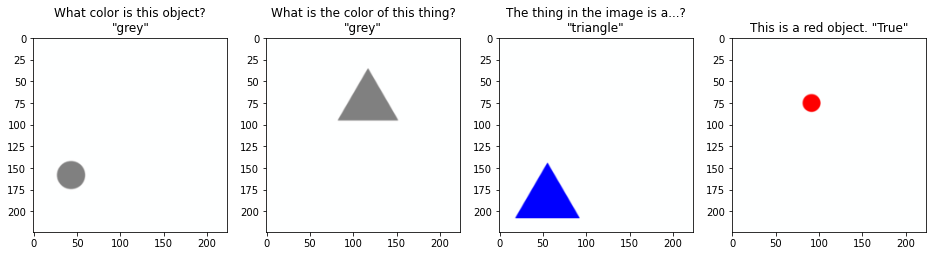

In [12]:
viz.show_samples(train_dataset)

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torchvision as tv
from cvqa import fairseq_misc

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)


def build_model(vocab, d=16, img_output_features=20):
    tokens_embeddings = fairseq_misc.build_embedding(vocab, d)
    prompt_encoder = models.build_fairseq_encoder(vocab, tokens_embeddings, 
      d=d, num_layers=1, ffn_dim=10, heads=1, layerdrop=0
    )
    vqa_decoder = models.build_fairseq_decoder(vocab, tokens_embeddings, 
      d=d, num_layers=1, ffn_dim=10, heads=1, layerdrop=0
    )
    img_perceptor = models.BasicImgModel(d, img_output_features)
    return models.VQAModelV1(prompt_encoder, img_perceptor, vqa_decoder)


model = build_model(train_dataset.vocab, d=10, img_output_features=10)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

trainer = trainers.VQATrainer(log_dir='runs/basic')
train_loss, train_acc, dev_acc = trainer.train(
    model, train_dataset, dev_dataset, 
    optimizer, num_epochs=3, batch_size=32
)

[epoch=0, train_acc=0.00, dev_acc=0.00] loss: 5.023: 100%|██████████| 4/4 [00:13<00:00,  3.36s/it]
[epoch=1, train_acc=0.00, dev_acc=0.00] loss: 4.872: 100%|██████████| 4/4 [00:13<00:00,  3.33s/it]
[epoch=2, train_acc=0.00, dev_acc=0.00] loss: 4.670: 100%|██████████| 4/4 [00:13<00:00,  3.31s/it]


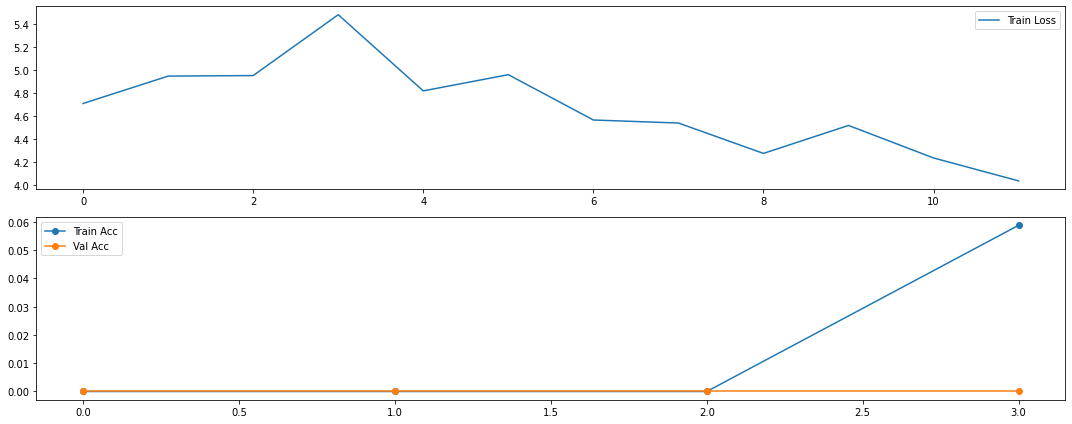

In [14]:
viz.plot_training(train_loss, train_acc, dev_acc)

Sample index: 9
Prompt: This is a red object.
Decoded encoded prompt: This is a red object. <pad> <pad> <pad> <pad> <pad>
True: True
Pred: False


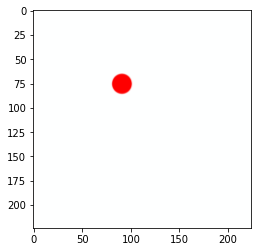

In [19]:
viz.test_natural_sample(model, train_dataset)

In [20]:
y_true, y_pred = trainer.get_predictions(model, train_dataset)

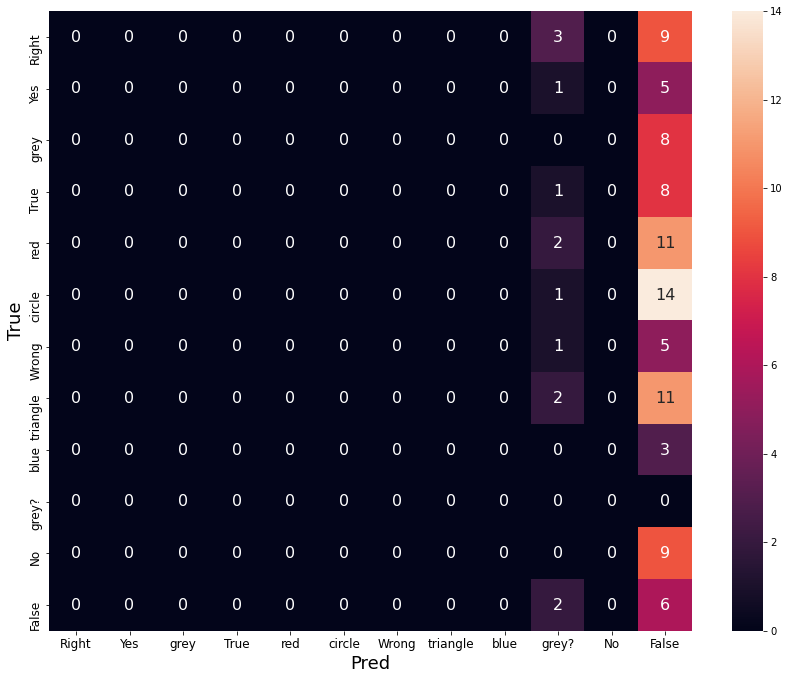

In [29]:
viz.one_word_conf_mat(y_true, y_pred, train_dataset.vocab)